# Simulações Deposição Balistica - 16 amostras

In [1]:
# importação dos objetos
from deposicao import DeposicaoBalistica
from rng import RNG_PCG
import numpy as np
import pdb
import time
from multiprocessing import Pool

def simular(deposicao):
    deposicao.simular()
    return deposicao

instancias_paralelas = 4
amostras = 16 * instancias_paralelas
tempo_maximo = 5 * 10 ** 4
comprimentos_subestratos = [1600]
z = (3/2)
coeficiente_tempo_maximo = 1

dados_medios = {
    L:  {
        'evolucao_subestratos': np.zeros((max(tempo_maximo, round(coeficiente_tempo_maximo * (L ** z))), L)),
        'interfaces': np.zeros(L),
        'tempo_maximo': (max(tempo_maximo, round(coeficiente_tempo_maximo * (L ** z)))),
        'rugosidades': np.zeros(max(tempo_maximo, round(coeficiente_tempo_maximo * (L ** z))))
    }
    for L in comprimentos_subestratos
}

# instanciando geradores de numeros aleatorios
rngs = [RNG_PCG() for i in range(instancias_paralelas)]

for L in comprimentos_subestratos:
    tempo_maximo = dados_medios[L]['tempo_maximo']
    
    # avancar o estado dos geradores de numeros aleatorios para cada instancia
    for i in range(1, instancias_paralelas):
        rngs[i].fast_forward(i * tempo_maximo)
    
    future_steps = 1
    for amostra in range(0,amostras,instancias_paralelas):
        # instancio instancias_paralelas de objetos de deposicao aleatoria
        instancias = []
        for i in range(instancias_paralelas):
            instancias.append(
                DeposicaoBalistica(L, rngs[i], tempo_maximo = tempo_maximo)
            )
        
        begin = time.time()
        # simulacao de instancias_paralelas deposicoes
        print('Simulacao das amostras {} a {}'.format(amostra + 1, amostra + instancias_paralelas))
        #instancias[0].simular()
        pool = Pool()
        deposicoes = pool.map(simular, instancias)
        pool.close()
        pool.join()
        print('Tempo Gasto: {:.2f}s'.format(time.time() - begin))
        
        # armazenar resultados
        for d in deposicoes:
            dados_medios[L]['evolucao_subestratos'] += d.altura_sitios / amostras
            dados_medios[L]['interfaces'] += d.altura_interface / amostras
            dados_medios[L]['rugosidades'] += d.rugosidade() / amostras
        
        # avancar geradores de numeros aleatorios
        for i in range(instancias_paralelas):
            rngs[i].fast_forward((i + future_steps * instancias_paralelas) * tempo_maximo)
        future_steps += 1

Simulacao das amostras 1 a 4
0.0%   0.0%   0.0%   5.0%   0.0%   5.0%   5.0%   10.0%   5.0%   10.0%   10.0%   15.0%   10.0%   15.0%   15.0%   20.0%   15.0%   20.0%   20.0%   25.0%   20.0%   25.0%   25.0%   30.0%   25.0%   30.0%   30.0%   35.0%   30.0%   35.0%   35.0%   40.0%   35.0%   40.0%   40.0%   45.0%   40.0%   45.0%   45.0%   50.0%   45.0%   50.0%   50.0%   55.0%   50.0%   55.0%   55.0%   60.0%   55.0%   60.0%   60.0%   65.0%   60.0%   65.0%   65.0%   70.0%   65.0%   70.0%   70.0%   75.0%   70.0%   75.0%   75.0%   80.0%   75.0%   80.0%   80.0%   85.0%   80.0%   85.0%   85.0%   90.0%   90.0%   85.0%   90.0%   95.0%   95.0%   90.0%   95.0%   fim
fim
95.0%   fim
fim
Tempo Gasto: 103.51s
Simulacao das amostras 5 a 8
0.0%   0.0%   0.0%   5.0%   0.0%   5.0%   5.0%   10.0%   5.0%   10.0%   10.0%   15.0%   10.0%   15.0%   15.0%   20.0%   15.0%   20.0%   20.0%   25.0%   20.0%   25.0%   25.0%   30.0%   25.0%   30.0%   30.0%   35.0%   30.0%   35.0%   35.0%   40.0%   35.0%   40.0%   40.0%   4

## Gráfico da Média da Evolução do Crescimento de Subestratos - Deposição Balística

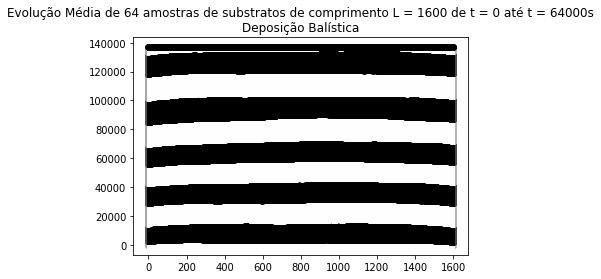

In [2]:
from simulacao_utils import plotar_interface, plotar_rugosidades, plotar_instantaneos

comutar_representacao = lambda r: 'wo' if r == 'ko' else 'ko'

t_comutacao = 1
for L in comprimentos_subestratos:
    plotar_instantaneos(
        'Evolução Média de {} amostras de substratos de comprimento L = {} de t = 0 até t = {}s\n'.format(
            amostras,
            L,
            dados_medios[L]['tempo_maximo']
        )
      + 'Deposição Balística',
        dados_medios[L]['interfaces'],
        [dados_medios[L]['evolucao_subestratos'][t] for t in range(0, dados_medios[L]['tempo_maximo'], dados_medios[L]['tempo_maximo']//800)],
        t_comutacao = t_comutacao,
        comutar_representacao = comutar_representacao
    )

## Média das Rugosidades em Função do Tempo - Deposição Balística

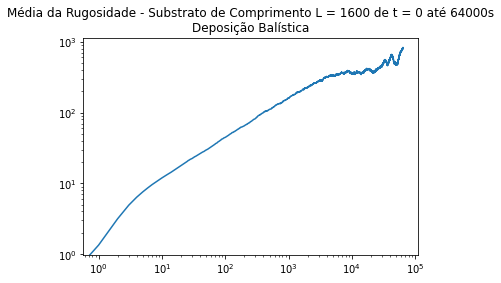

In [3]:
import importlib
import simulacao_utils
importlib.reload(simulacao_utils)

for L in comprimentos_subestratos:
    simulacao_utils.plotar_rugosidades('Média da Rugosidade - Substrato de Comprimento L = {} de t = 0 até {}s\n'.format(L, dados_medios[L]['tempo_maximo'])
                     + 'Deposição Balística',
                      [dados_medios[L]['rugosidades']], logscale = True)

## Salvar os dados para uso posterior

In [4]:
import pickle

for L in comprimentos_subestratos:
    f = open('simulacoes/DB/L_{}'.format(L), 'wb')
    pickle.dump(dados_medios, f)
    f.close()